In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 加载数据集
df = pd.read_csv('C:/Users/zhouxiinlei/Documents/GitHub/ml_WaterAnalytics/dataset/Lake/Lake_Bilancino.csv')
df.head()

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,03/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
1,04/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2,05/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
3,06/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
4,07/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31


In [4]:
data_info = df.info()
data_description = df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  6603 non-null   object 
 1   Rainfall_S_Piero      6026 non-null   float64
 2   Rainfall_Mangona      6026 non-null   float64
 3   Rainfall_S_Agata      6026 non-null   float64
 4   Rainfall_Cavallina    6026 non-null   float64
 5   Rainfall_Le_Croci     6026 non-null   float64
 6   Temperature_Le_Croci  6025 non-null   float64
 7   Lake_Level            6603 non-null   float64
 8   Flow_Rate             6582 non-null   float64
dtypes: float64(8), object(1)
memory usage: 464.4+ KB


Date                      0
Rainfall_S_Piero        577
Rainfall_Mangona        577
Rainfall_S_Agata        577
Rainfall_Cavallina      577
Rainfall_Le_Croci       577
Temperature_Le_Croci    578
Lake_Level                0
Flow_Rate                21
dtype: int64


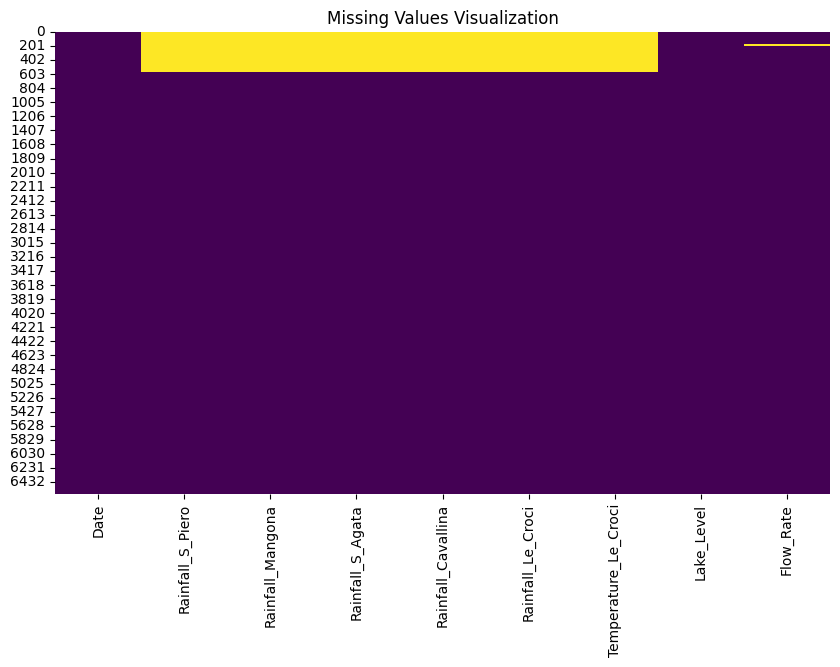

In [5]:
# 缺失值统计
missing_counts = df.isnull().sum()
print(missing_counts)

# 缺失值可视化
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Visualization')
plt.show()

In [6]:
# 删除包含空白数据的行
df_cleaned = df.dropna().reset_index(drop=True)

In [7]:
# 使用滑动窗口平滑数据，窗口大小设置为7
window_size = 7
df_smoothed = df_cleaned.copy()

# 对除 "Date" 列外的所有列应用滑动窗口平滑
for column in df_cleaned.columns[1:]:
    df_smoothed[column] = df_cleaned[column].rolling(window=window_size).mean()

# 剔除开始部分的NaN值（由于滑动窗口的效果）
df_smoothed = df_smoothed.dropna().reset_index(drop=True)

# 将"Date"列转换为日期格式
df_smoothed['Date'] = pd.to_datetime(df_smoothed['Date'], dayfirst=True)

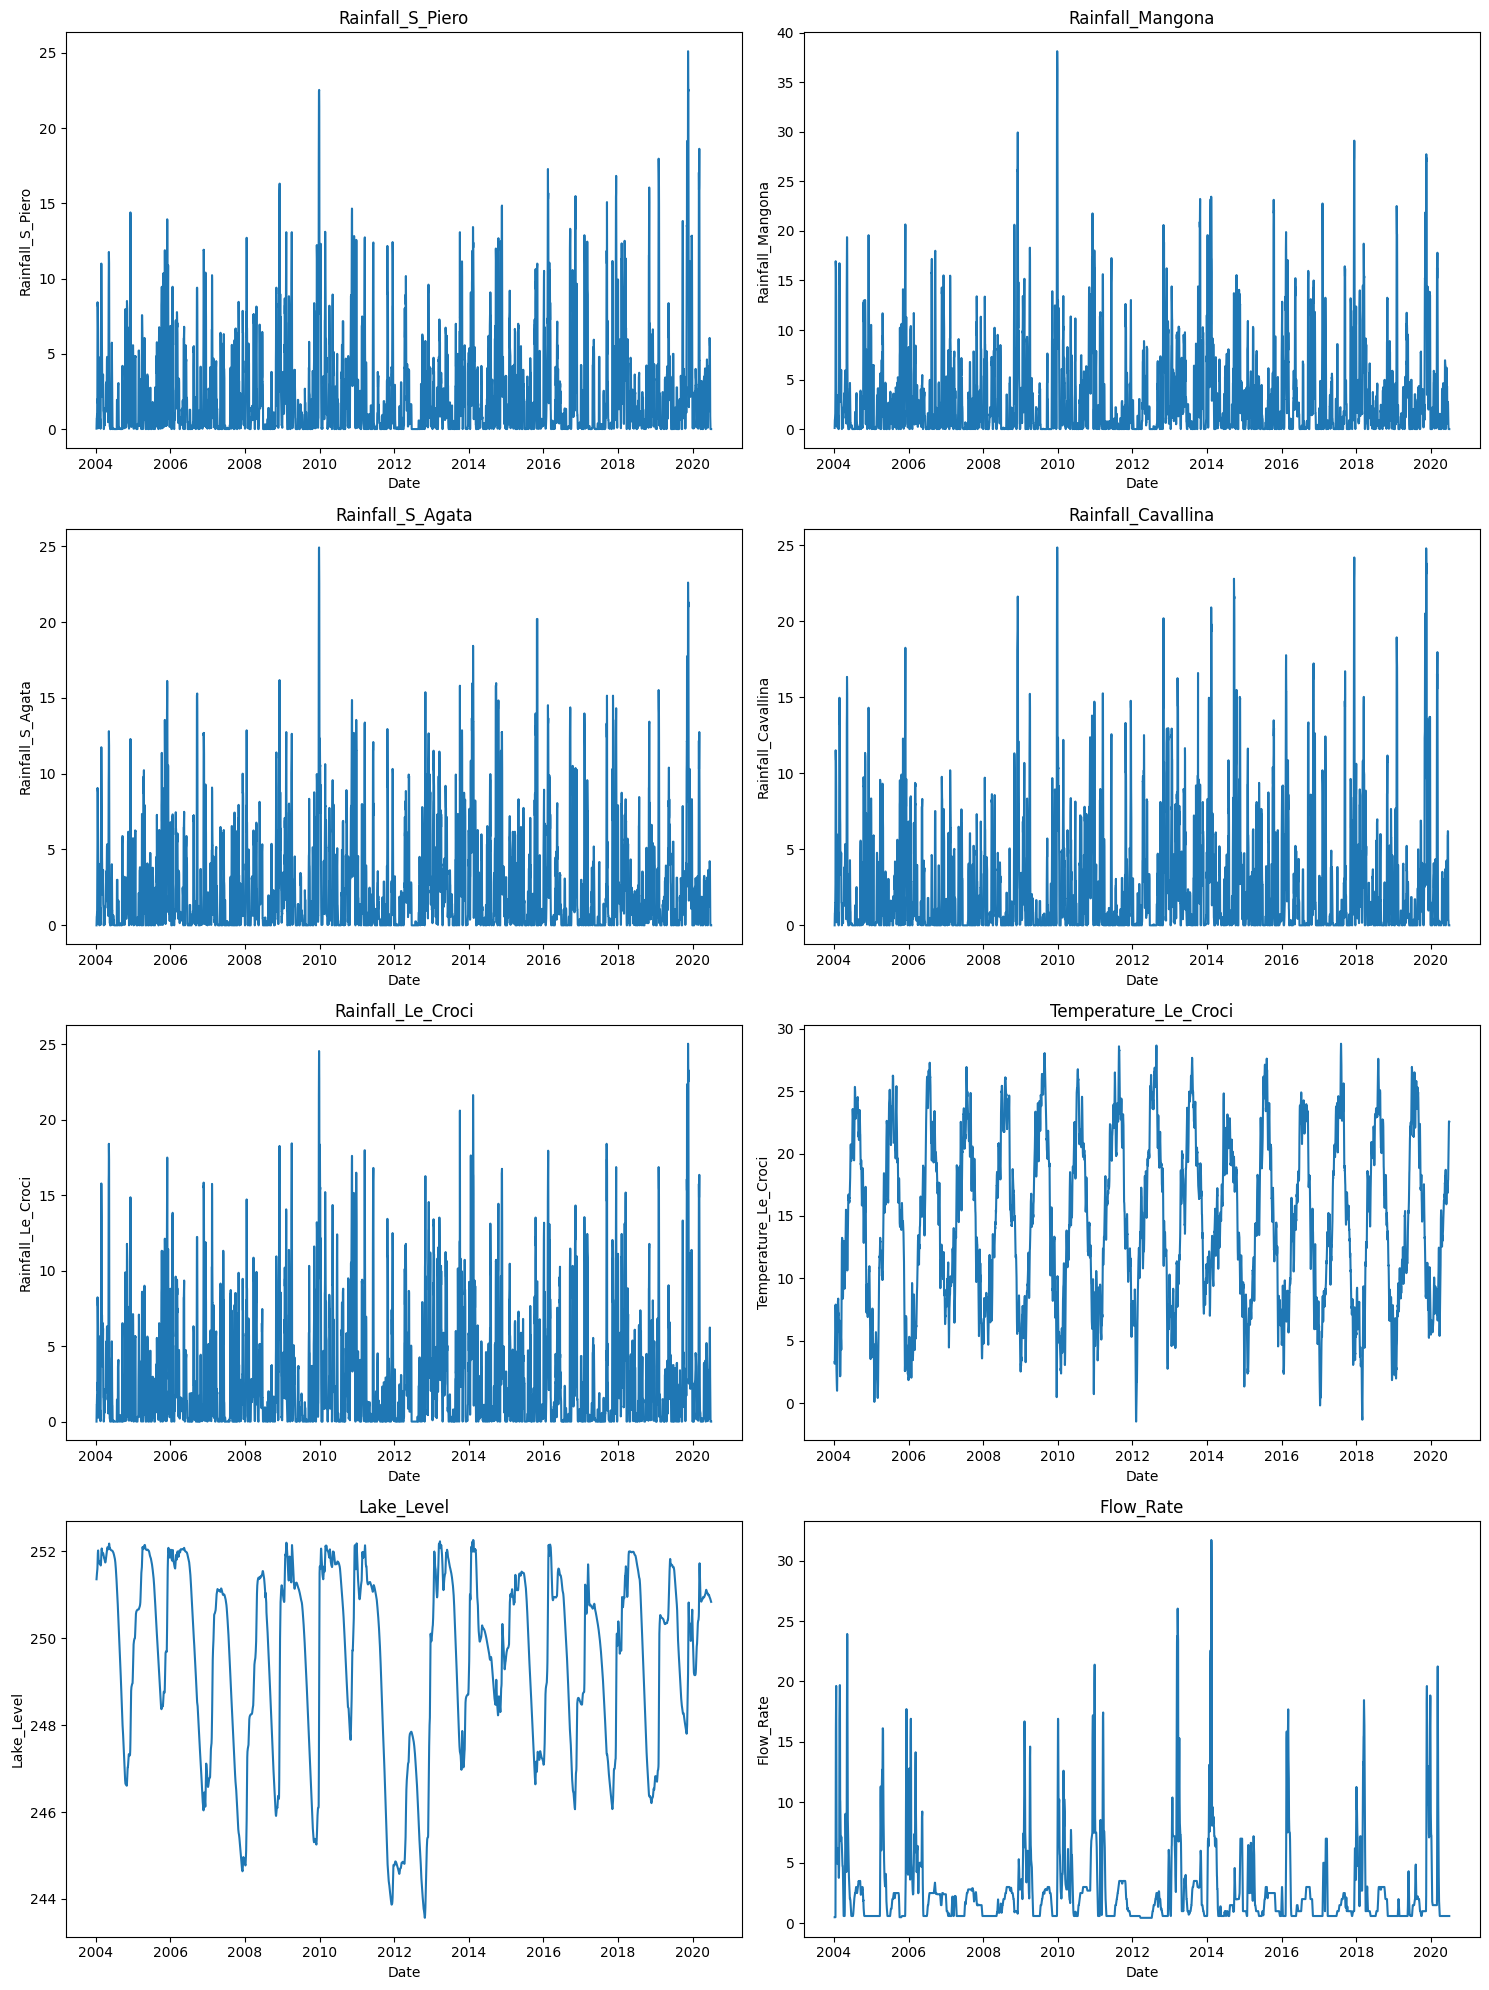

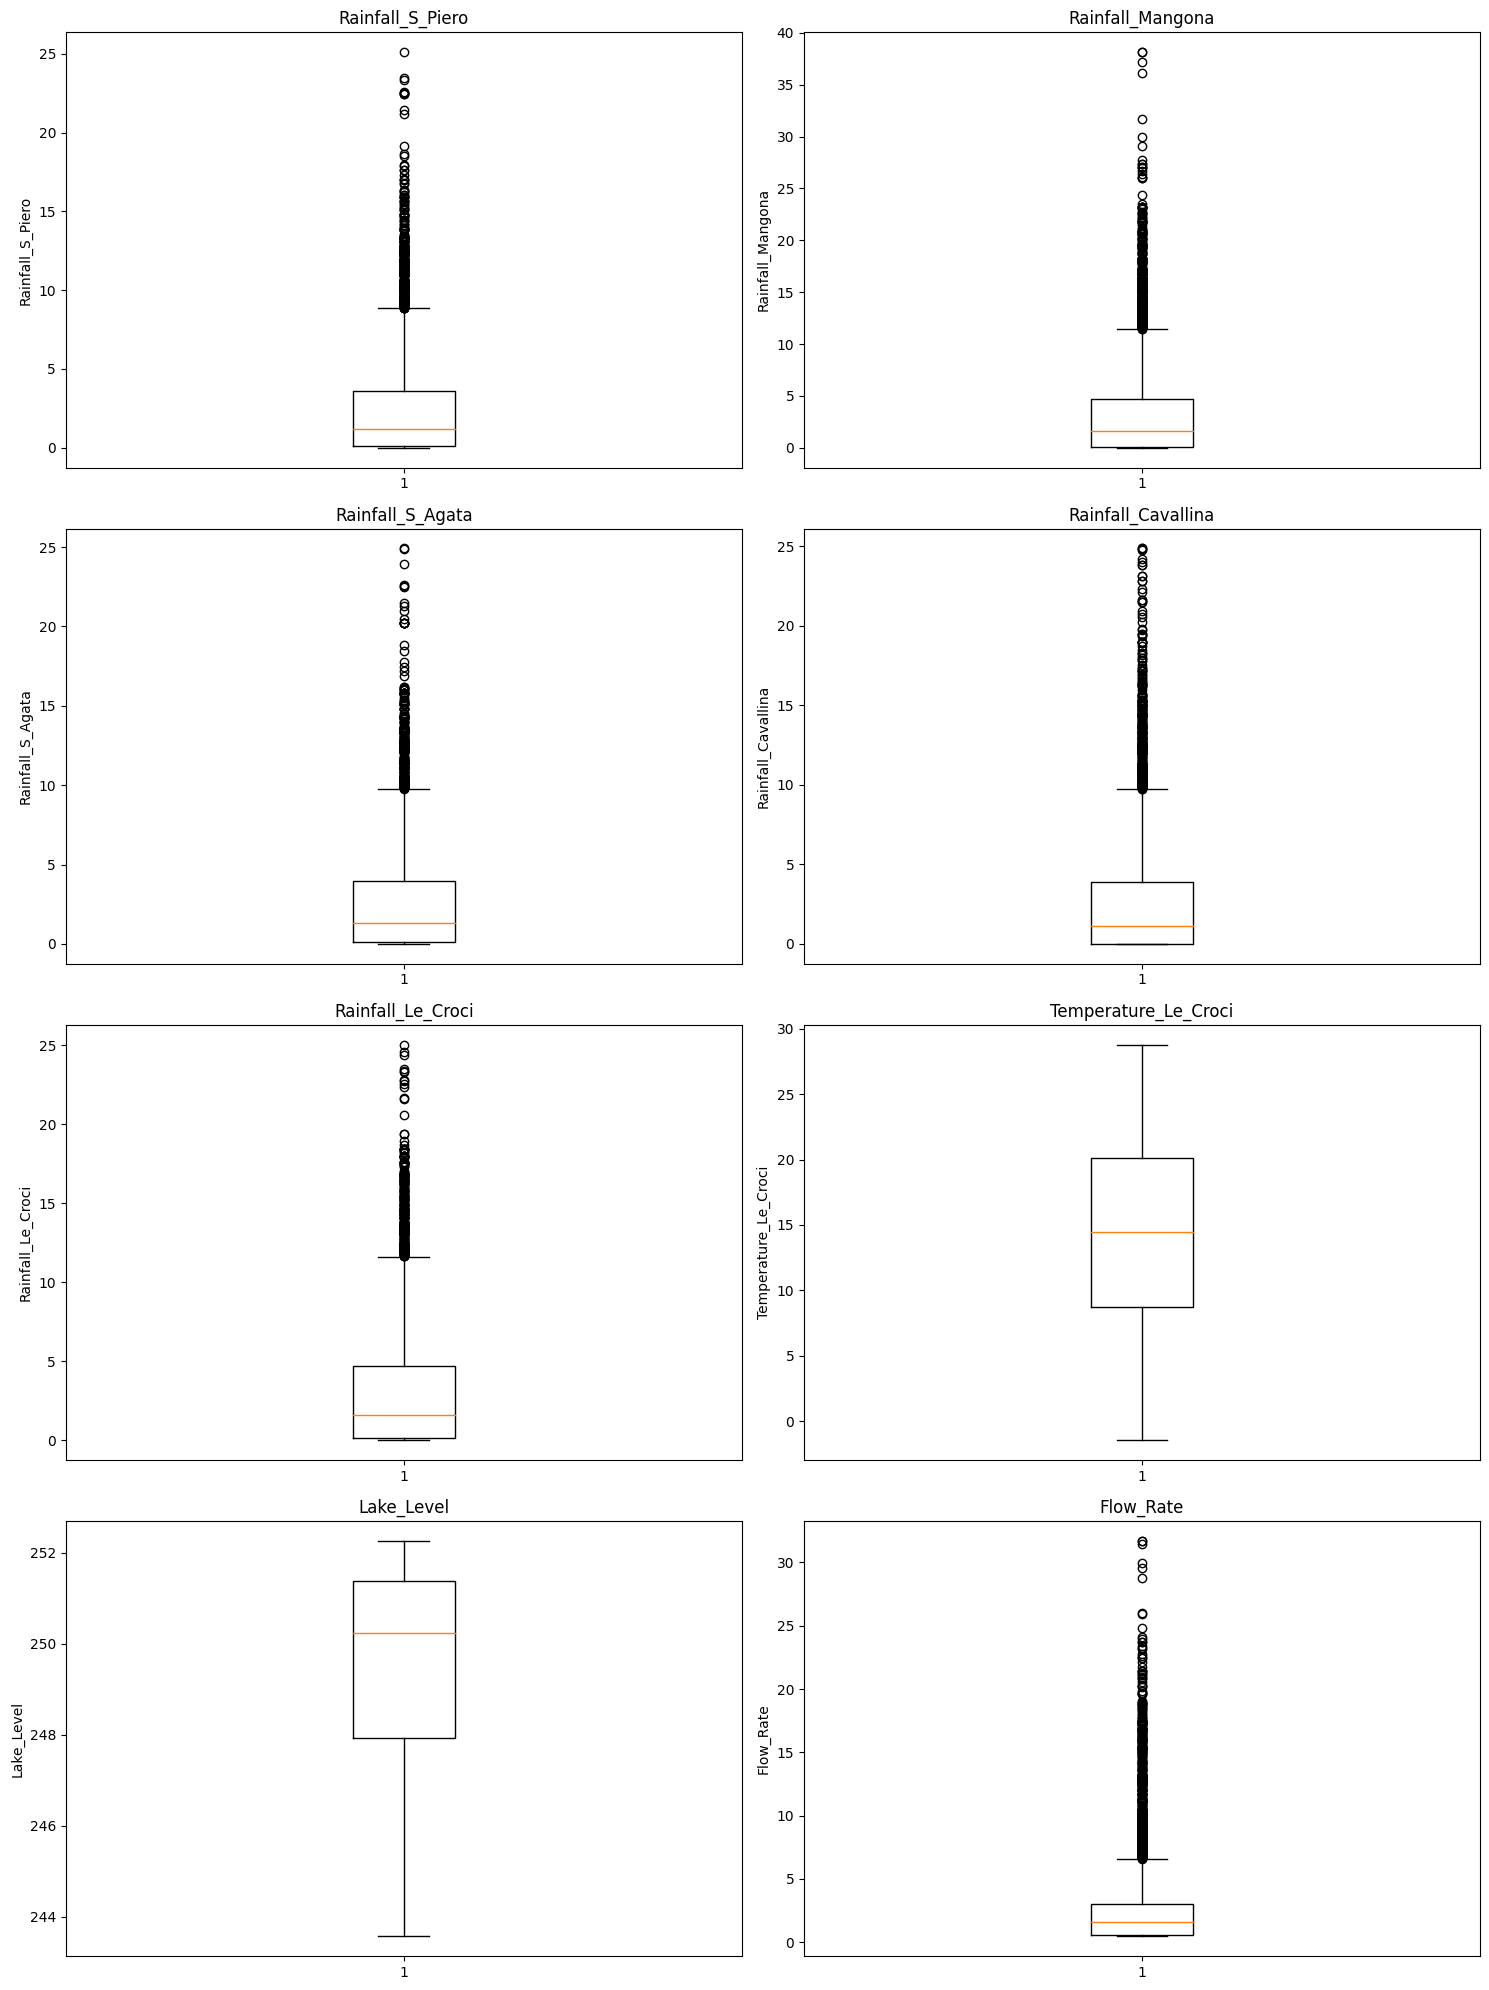

In [8]:
# 设置图的大小
plt.figure(figsize=(15, 20))
# 绘制每个数值变量随时间的变化
for i, column in enumerate(df_smoothed.columns[1:], 1):
    plt.subplot(4, 2, i)
    plt.plot(df_smoothed['Date'], df_smoothed[column])
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel(column)
plt.tight_layout()
plt.show()

# 设置图的大小
plt.figure(figsize=(15, 20))
# 绘制每个数值变量的箱线图
for i, column in enumerate(df_smoothed.columns[1:], 1):
    plt.subplot(4, 2, i)
    plt.boxplot(df_smoothed[column])
    plt.title(column)
    plt.ylabel(column)
plt.tight_layout()
plt.show()

processed_data_path = './dataset/Lake/processed_Lake_Bilancino.csv'
df_smoothed.to_csv(processed_data_path, index=False)

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Extracting the features and target variables
processed_data=pd.read_csv('./dataset/Lake/processed_Lake_Bilancino.csv')
features = processed_data.drop(['Date', 'Lake_Level', 'Flow_Rate'], axis=1)
target_lake_level = processed_data['Lake_Level']
target_flow_rate = processed_data['Flow_Rate']

# Scaling the features
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(features)

# Scaling the target variables
scaler_lake_level = MinMaxScaler()
lake_level_scaled = scaler_lake_level.fit_transform(target_lake_level.values.reshape(-1, 1))
flow_rate_scaled = scaler_lake_level.fit_transform(target_flow_rate.values.reshape(-1, 1))

# Function to create LSTM samples
def create_lstm_samples(data, label, window_size=7):
    X, Y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        Y.append(label[i+window_size])
    return np.array(X), np.array(Y)

# Creating LSTM samples for Lake_Level
X_lake_level, y_lake_level = create_lstm_samples(scaled_features, lake_level_scaled, window_size=7)
X_flow_rate, y_flow_rate = create_lstm_samples(scaled_features, flow_rate_scaled, window_size=7)

# Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(X_lake_level))
X_train_lake, X_test_lake = X_lake_level[:train_size], X_lake_level[train_size:]
y_train_lake, y_test_lake = y_lake_level[:train_size], y_lake_level[train_size:]

X_train_flow, X_test_flow = X_flow_rate[:train_size], X_flow_rate[train_size:]
y_train_flow, y_test_flow = y_flow_rate[:train_size], y_flow_rate[train_size:]

X_train_lake.shape, X_train_flow.shape


c:\Users\zhouxiinlei\Anaconda3\envs\pytorch1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


((4809, 7, 6), (4809, 7, 6))

In [10]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch 
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.linear(out[:, -1, :]) 
        return out



In [22]:
# Hyperparameters
input_dim = 6
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 1000
learning_rate = 0.01

# Convert dataset into tensors
X_train_tensor_lake = torch.FloatTensor(X_train_lake)
y_train_tensor_lake = torch.FloatTensor(y_train_lake)

X_test_tensor_lake = torch.FloatTensor(X_test_lake)
y_test_tensor_lake = torch.FloatTensor(y_test_lake)

# Define the LSTM model, loss function and optimizer
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    outputs = model(X_train_tensor_lake)
    optimizer.zero_grad()
    
    # Obtain the loss function
    loss = criterion(outputs, y_train_tensor_lake)
    loss.backward()
    
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    
# Model evaluation on test data
model.eval()
test_outputs_lake = model(X_test_tensor_lake)
mse_loss = criterion(test_outputs_lake, y_test_tensor_lake)
# Compute RMSE
rmse_loss = torch.sqrt(mse_loss)

# Compute MAE
mae_loss = torch.mean(torch.abs(test_outputs_lake - y_test_tensor_lake))

print(f'MSE Loss on test data: {mse_loss.item()}')
print(f'RMSE Loss on test data: {rmse_loss.item()}')
print(f'MAE Loss on test data: {mae_loss.item()}')


Epoch 100/1000, Loss: 0.06831753253936768
Epoch 200/1000, Loss: 0.0682561919093132
Epoch 300/1000, Loss: 0.06812045723199844
Epoch 400/1000, Loss: 0.06614363193511963
Epoch 500/1000, Loss: 0.06299933791160583
Epoch 600/1000, Loss: 0.058816008269786835
Epoch 700/1000, Loss: 0.053806956857442856
Epoch 800/1000, Loss: 0.05067870020866394
Epoch 900/1000, Loss: 0.04420068860054016
Epoch 1000/1000, Loss: 0.040762707591056824
MSE Loss on test data: 0.055840279906988144
RMSE Loss on test data: 0.23630549013614655
MAE Loss on test data: 0.18989036977291107


In [12]:
X_train_flow, X_test_flow = X_flow_rate[:train_size], X_flow_rate[train_size:]
y_train_flow, y_test_flow = y_flow_rate[:train_size], y_flow_rate[train_size:]

# Hyperparameters
input_dim = 6
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 2000
learning_rate = 0.01

# Convert dataset into tensors
X_train_tensor_flow = torch.FloatTensor(X_train_flow)
y_train_tensor_flow = torch.FloatTensor(y_train_flow)

X_test_tensor_flow = torch.FloatTensor(X_test_flow)
y_test_tensor_flow = torch.FloatTensor(y_test_flow)

# Define the LSTM model, loss function and optimizer
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    outputs = model(X_train_tensor_flow)
    optimizer.zero_grad()
    
    # Obtain the loss function
    loss = criterion(outputs, y_train_tensor_flow)
    loss.backward()
    
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    
# Model evaluation on test data
model.eval()
test_outputs_flow = model(X_test_tensor_flow)
mse_loss = criterion(test_outputs_flow, y_test_tensor_flow)
print(f'MSE Loss on test data: {mse_loss.item()}')

Epoch 100/2000, Loss: 0.00800158828496933
Epoch 200/2000, Loss: 0.006514217704534531
Epoch 300/2000, Loss: 0.00533492024987936
Epoch 400/2000, Loss: 0.00414643157273531
Epoch 500/2000, Loss: 0.003257970092818141
Epoch 600/2000, Loss: 0.0025051666889339685
Epoch 700/2000, Loss: 0.002220205729827285
Epoch 800/2000, Loss: 0.0016124364919960499
Epoch 900/2000, Loss: 0.0015849447809159756
Epoch 1000/2000, Loss: 0.001303809112869203
Epoch 1100/2000, Loss: 0.001271696062758565
Epoch 1200/2000, Loss: 0.0009661372168920934
Epoch 1300/2000, Loss: 0.0008298989851027727
Epoch 1400/2000, Loss: 0.0007320416043512523
Epoch 1500/2000, Loss: 0.0010655983351171017
Epoch 1600/2000, Loss: 0.0009598295437172055
Epoch 1700/2000, Loss: 0.0005821066442877054
Epoch 1800/2000, Loss: 0.0006835502572357655
Epoch 1900/2000, Loss: 0.0005190953379496932
Epoch 2000/2000, Loss: 0.0005387834971770644
MSE Loss on test data: 0.014398963190615177


In [13]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

In [14]:
# Hyperparameters
input_dim = 6 * 7  # 6 features for 7 days
output_dim = 1
learning_rate = 0.01
num_epochs = 2000

# Reshape data for linear regression (flatten the sequence dimension)
X_train_flat_lake = X_train_lake.reshape(X_train_lake.shape[0], -1)
X_test_flat_lake = X_test_lake.reshape(X_test_lake.shape[0], -1)

X_train_flat_flow = X_train_flow.reshape(X_train_flow.shape[0], -1)
X_test_flat_flow = X_test_flow.reshape(X_test_flow.shape[0], -1)

# Convert to tensors
X_train_tensor_flat_flow = torch.FloatTensor(X_train_flat_flow)
y_train_tensor_flow = torch.FloatTensor(y_train_flow)
X_test_tensor_flat_flow = torch.FloatTensor(X_test_flat_flow)
y_test_tensor_flow = torch.FloatTensor(y_test_flow)

# Define the model, loss, and optimizer
linear_model = LinearRegressionModel(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(linear_model.parameters(), lr=learning_rate)

# Training loop for Flow_Rate
for epoch in range(num_epochs):
    outputs = linear_model(X_train_tensor_flat_flow)
    optimizer.zero_grad()

    # Compute the loss
    loss = criterion(outputs, y_train_tensor_flow)
    loss.backward()

    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluate the model on test data
linear_model.eval()
test_outputs = linear_model(X_test_tensor_flat_flow)
mse_loss = criterion(test_outputs, y_test_tensor_flow)
print(f'MSE Loss on test data for Flow_Rate using Linear Regression: {mse_loss.item()}')


Epoch 100/2000, Loss: 0.009034539572894573
Epoch 200/2000, Loss: 0.008945556357502937
Epoch 300/2000, Loss: 0.008917754516005516
Epoch 400/2000, Loss: 0.008900301530957222
Epoch 500/2000, Loss: 0.008889437653124332
Epoch 600/2000, Loss: 0.008882822468876839
Epoch 700/2000, Loss: 0.008878718130290508
Epoch 800/2000, Loss: 0.008876008912920952
Epoch 900/2000, Loss: 0.008874068967998028
Epoch 1000/2000, Loss: 0.008872566744685173
Epoch 1100/2000, Loss: 0.00889534130692482
Epoch 1200/2000, Loss: 0.008870433084666729
Epoch 1300/2000, Loss: 0.008869627490639687
Epoch 1400/2000, Loss: 0.008869193494319916
Epoch 1500/2000, Loss: 0.008868435397744179
Epoch 1600/2000, Loss: 0.00887348037213087
Epoch 1700/2000, Loss: 0.008867548778653145
Epoch 1800/2000, Loss: 0.008867182768881321
Epoch 1900/2000, Loss: 0.008984796702861786
Epoch 2000/2000, Loss: 0.008866573683917522
MSE Loss on test data for Flow_Rate using Linear Regression: 0.009281699545681477


In [15]:
# Convert Lake_Level data to tensors
X_train_tensor_flat_lake = torch.FloatTensor(X_train_flat_lake)
y_train_tensor_lake = torch.FloatTensor(y_train_lake)
X_test_tensor_flat_lake = torch.FloatTensor(X_test_flat_lake)
y_test_tensor_lake = torch.FloatTensor(y_test_lake)

linear_model_lake = LinearRegressionModel(input_dim, output_dim)
optimizer_lake = torch.optim.Adam(linear_model_lake.parameters(), lr=learning_rate)

# Training loop for Lake_Level
for epoch in range(num_epochs):
    outputs_lake = linear_model_lake(X_train_tensor_flat_lake)
    optimizer_lake.zero_grad()

    # Compute the loss
    loss_lake = criterion(outputs_lake, y_train_tensor_lake)
    loss_lake.backward()

    optimizer_lake.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss for Lake_Level: {loss_lake.item()}")

# Evaluate the model on test data for Lake_Level
linear_model_lake.eval()
test_outputs_lake = linear_model_lake(X_test_tensor_flat_lake)
mse_loss_lake = criterion(test_outputs_lake, y_test_tensor_lake)
print(f'MSE Loss on test data for Lake_Level using Linear Regression: {mse_loss_lake.item()}')


Epoch 100/2000, Loss for Lake_Level: 0.08568302541971207
Epoch 200/2000, Loss for Lake_Level: 0.07137421518564224
Epoch 300/2000, Loss for Lake_Level: 0.0673152506351471
Epoch 400/2000, Loss for Lake_Level: 0.06636980175971985
Epoch 500/2000, Loss for Lake_Level: 0.06601166725158691
Epoch 600/2000, Loss for Lake_Level: 0.06576766073703766
Epoch 700/2000, Loss for Lake_Level: 0.06558089703321457
Epoch 800/2000, Loss for Lake_Level: 0.06544079631567001
Epoch 900/2000, Loss for Lake_Level: 0.06533896923065186
Epoch 1000/2000, Loss for Lake_Level: 0.06526690721511841
Epoch 1100/2000, Loss for Lake_Level: 0.06521671265363693
Epoch 1200/2000, Loss for Lake_Level: 0.06518176943063736
Epoch 1300/2000, Loss for Lake_Level: 0.06515692174434662
Epoch 1400/2000, Loss for Lake_Level: 0.06513843685388565
Epoch 1500/2000, Loss for Lake_Level: 0.0651237815618515
Epoch 1600/2000, Loss for Lake_Level: 0.06511133909225464
Epoch 1700/2000, Loss for Lake_Level: 0.06510010361671448
Epoch 1800/2000, Loss for

In [16]:
lstm_predictions = test_outputs_flow.detach().numpy()
linear_predictions = linear_model(X_test_tensor_flat_flow).detach().numpy()
true_values = y_test_tensor_flow.detach().numpy()

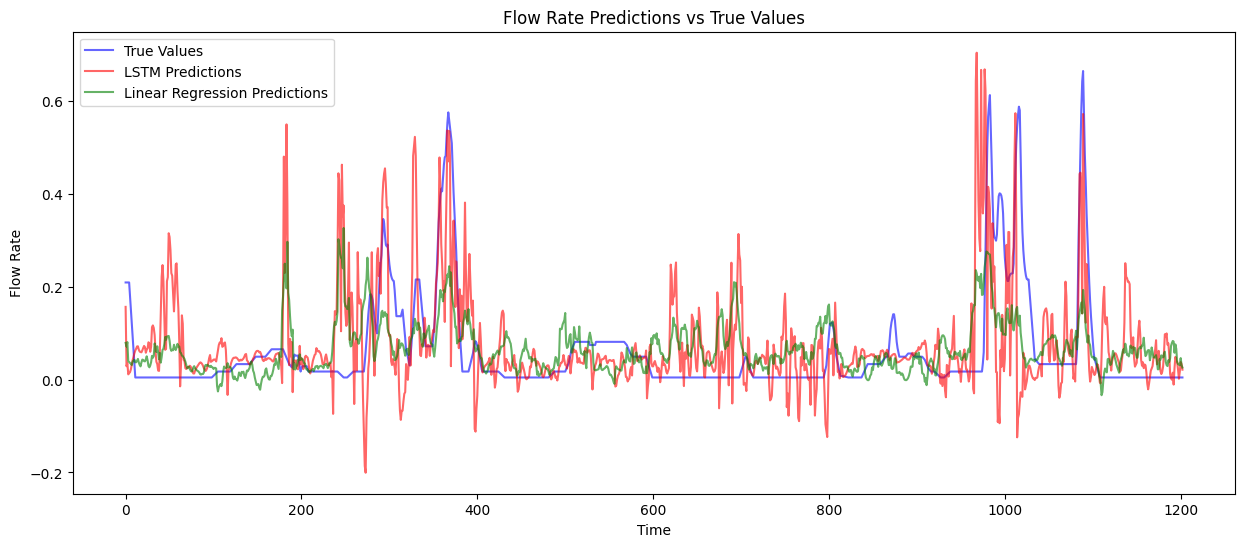

In [17]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(15, 6))

# Plot the true values
plt.plot(true_values, label='True Values', color='blue', alpha=0.6)

# Plot the predictions from LSTM
plt.plot(lstm_predictions, label='LSTM Predictions', color='red', alpha=0.6)

# Plot the predictions from Linear Regression
plt.plot(linear_predictions, label='Linear Regression Predictions', color='green', alpha=0.6)

# Set the title and labels
plt.title('Flow Rate Predictions vs True Values')
plt.xlabel('Time')
plt.ylabel('Flow Rate')
plt.legend()

# Show the plot
plt.show()

In [18]:
lstm_predictions_lake = test_outputs_lake.detach().numpy()  # Replace with your LSTM predictions for Lake_Level
linear_predictions_lake = linear_model(X_test_tensor_flat_lake).detach().numpy()  # Replace with your linear regression predictions for Lake_Level
true_values_lake = y_test_tensor_lake.detach().numpy()


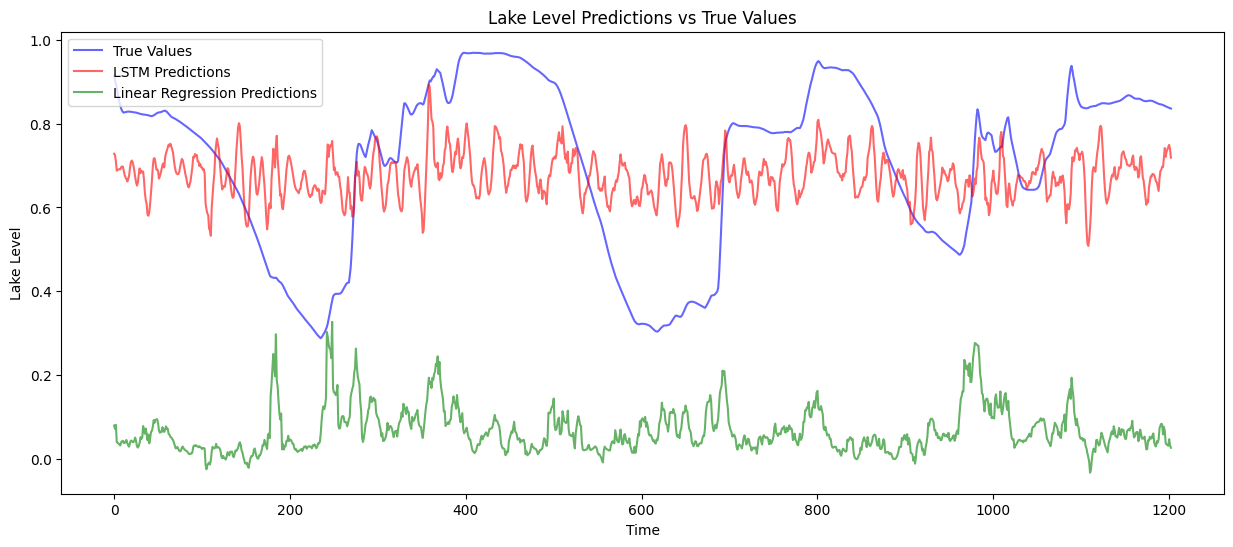

In [19]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(15, 6))

# Plot the true values
plt.plot(true_values_lake, label='True Values', color='blue', alpha=0.6)

# Plot the predictions from LSTM
plt.plot(lstm_predictions_lake, label='LSTM Predictions', color='red', alpha=0.6)

# Plot the predictions from Linear Regression
plt.plot(linear_predictions_lake, label='Linear Regression Predictions', color='green', alpha=0.6)

# Set the title and labels
plt.title('Lake Level Predictions vs True Values')
plt.xlabel('Time')
plt.ylabel('Lake Level')
plt.legend()

# Show the plot
plt.show()
